In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
from torchvision import transforms

import h5py

from tqdm import tqdm

In [2]:
device = torch.device('cuda')

## Data

In [3]:
torch.use_deterministic_algorithms(True)

import os

# Variable must be set to allow deterministic
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

torch_rng = torch.manual_seed(777)
np_rng = np.random.default_rng(777)

np.random.seed(777)

In [4]:
# Non bitsliced
#train_hdf = h5py.File("C:/Data/simpleserial-aes-500000-diff-profile.hdf5")
#val_test_hdf = h5py.File("C:/Data/simpleserial-aes-500-diff.hdf5")

In [5]:
train_hdf = h5py.File("C:/Data/simpleserial-aes-fix-500000-diff-profile.hdf5")

In [6]:
val_test_hdf = h5py.File("C:/Data/simpleserial-aes-fix-500-diff.hdf5")

In [7]:
train_traces = torch.Tensor(np.array(train_hdf['trace']))
train_plaintexts = torch.Tensor(np.array(train_hdf['data']))
train_keys = torch.Tensor(np.array(train_hdf['key']))

In [8]:
val_test_traces = torch.Tensor(np.array(val_test_hdf['trace']))
val_test_plaintexts = torch.Tensor(np.array(val_test_hdf['data']))
val_test_keys = torch.Tensor(np.array(val_test_hdf['key']))

In [9]:
print(f"Train traces shape: {train_traces.shape}")
print(f"Train keys shape: {train_keys.shape}")
print(f"Train plaintexts shape: {train_plaintexts.shape}")

print(f"Test traces shape: {val_test_traces.shape}")
print(f"Test keys shape: {val_test_keys.shape}")
print(f"Test plaintexts shape: {val_test_plaintexts.shape}")

Train traces shape: torch.Size([500000, 5000])
Train keys shape: torch.Size([500000, 16])
Train plaintexts shape: torch.Size([500000, 32])
Test traces shape: torch.Size([1000, 500, 5000])
Test keys shape: torch.Size([1000, 16])
Test plaintexts shape: torch.Size([1000, 500, 32])


### Computing S-box output

In [10]:
s_box = [
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16,
]

inverted_s_box = [0] * 256

for idx, bytevalue in enumerate(s_box):
    inverted_s_box[bytevalue] = idx

In [ ]:
# Only do first block, what mode are we encrypting with?
train_sbox_output = torch.empty((500000,16))
val_test_sbox_output = torch.empty((1000,500,16))

for idx, (key, plaintext) in enumerate(zip(train_keys, train_plaintexts)):

    block = plaintext.clone()[:16]

    block.map_(key, lambda x,y: s_box[int(x) ^ int(y)])

    block = block.long()

    train_sbox_output[idx] = block

for key_idx in range(val_test_traces.shape[0]):
    for idx, (key, plaintext) in enumerate(zip(val_test_keys[key_idx], val_test_plaintexts[key_idx])):

        block = plaintext.clone()[:16]

        block.map_(key, lambda x,y: s_box[int(x) ^ int(y)])

        block = block.long()

        val_test_sbox_output[key_idx, idx] = block

In [12]:
print(train_sbox_output.shape)
print(val_test_sbox_output.shape)

torch.Size([500000, 16])
torch.Size([1000, 500, 16])


### Sample

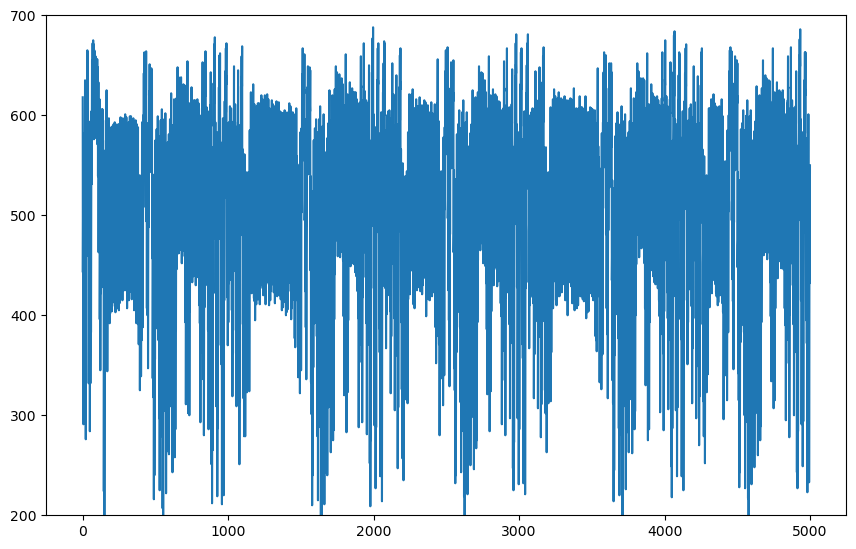

In [13]:
fig = plt.figure(1,(8.0, 5.0))

ax = fig.add_axes((1.0, 1.0, 1.0, 1.0))
ax.set_ylim(200.0, 700.0)

ax.plot(np.arange(5000), train_traces[99000])

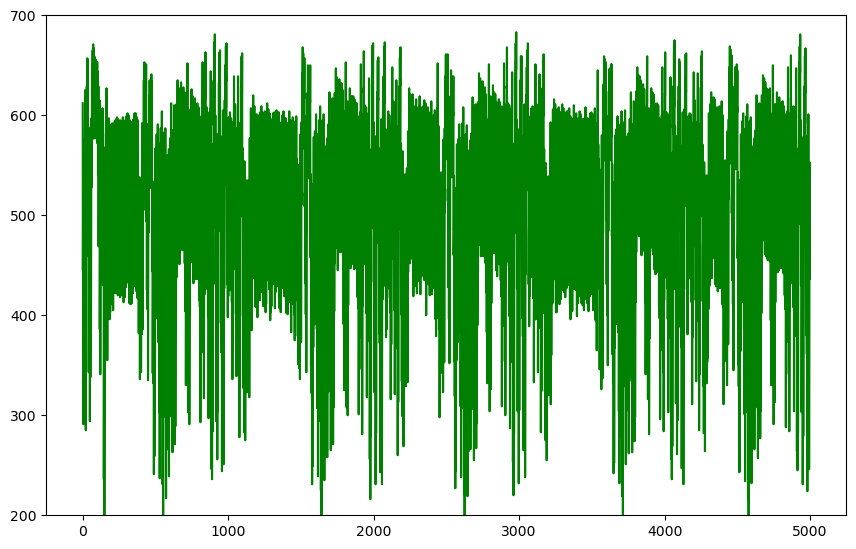

In [14]:
fig = plt.figure(1,(8.0, 5.0))
ax = fig.add_axes((1.0, 1.0, 1.0, 1.0))
ax.set_ylim(200.0, 700.0)

ax.plot(np.arange(5000), val_test_traces[450,4], color='green')

In [15]:
train_traces_trunc = train_traces[..., :1000]
val_test_traces_trunc = val_test_traces[..., :1000]

print(train_traces_trunc.shape)
print(val_test_traces_trunc.shape)

torch.Size([500000, 1000])
torch.Size([1000, 500, 1000])


In [16]:
train_traces_mean = train_traces_trunc.mean()
train_traces_std = train_traces_trunc.std()

In [17]:
train_traces_norm = (train_traces_trunc - train_traces_mean) / train_traces_std
val_test_traces_norm = (val_test_traces_trunc - train_traces_mean) / train_traces_std

## Dataset

In [18]:
class TrainingTraceSet(Dataset):
    def __init__(self, traces : torch.Tensor, keys, subkey_idx):

        self.traces = traces
        self.keys = keys[..., subkey_idx]

    def __len__(self):
        return self.traces.shape[0]
    
    def __getitem__(self, idx) -> tuple[torch.Tensor, torch.Tensor]:
        sample = self.traces[idx]
        target = self.keys[idx]
        return (sample, target)

In [19]:
class TestingTraceSet(Dataset):
    def __init__(self, traces, keys, subkey_idx):

        self.traces = traces
        self.keys = keys[..., subkey_idx]

    def __len__(self):
        return self.traces.shape[0]
    
    def __getitem__(self, idx):
        # One sample, N traces
        traces = self.traces[idx]
        key = self.keys[..., idx]

        return (traces, key)

In [20]:
class SboxTestingTraceSet(Dataset):
    def __init__(self, traces, plaintexts, keys, subbyte_idx):

        self.traces = traces

        # Plaintext must be included to map possible sbox outpouts back to keys
        self.plaintexts = plaintexts[..., subbyte_idx]
        self.keys = keys[..., subbyte_idx].squeeze()

    def __len__(self):
        return self.traces.shape[0]
    
    def __getitem__(self, idx):
        # One sample, N traces, N plaintexts, single key
        traces = self.traces[idx]
        plaintexts = self.plaintexts[idx].squeeze()
        key = self.keys[idx]

        return (traces, plaintexts, key)

## Model

In [21]:
# Zhang2019
class CNN_ZHANG(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.network : nn.Sequential = nn.Sequential(
            
            nn.Conv1d(1, 64, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Conv1d(64, 128, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Conv1d(128, 256, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Conv1d(256, 512, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Conv1d(512, 512, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Flatten(),

            nn.Linear(10752, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 256),
            # Cross entropy expects raw logits
            # https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
        )

    def forward(self, x):

        # Add channel dimension for conv
        x = x.unsqueeze(1)

        output = self.network(x)

        return output


In [49]:
# different name matching older .pt files
class SCACNN(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.network : nn.Sequential = nn.Sequential(
            
            nn.Conv1d(1, 64, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Conv1d(64, 128, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Conv1d(128, 256, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Conv1d(256, 512, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Conv1d(512, 512, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Flatten(),

            nn.Linear(10752, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 256),
            # Cross entropy expects raw logits
            # https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
        )

    def forward(self, x):

        # Add channel dimension for conv
        x = x.unsqueeze(1)

        output = self.network(x)

        return output


In [22]:
# Zhang2019
class CNN_Hettwer(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.network : nn.Sequential = nn.Sequential(
            
            nn.Conv1d(1, 8, 8),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            nn.Dropout(0.3),

            nn.Conv1d(8, 16, 8),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            nn.Dropout(0.3),

            nn.Conv1d(16, 32, 8),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            nn.Dropout(0.3),

            nn.Conv1d(32, 64, 8),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            nn.Dropout(0.3),

            nn.Flatten(),

            nn.Linear(3520, 20),
            nn.ReLU(),
            nn.Linear(20, 256),
            # Cross entropy expects raw logits
            # https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
        )

    def forward(self, x):

        # Add channel dimension for conv
        x = x.unsqueeze(1)

        output = self.network(x)

        return output

## Computing keyrank

In [23]:
from importlib import reload
import keyrank_rs

# Changes to external module don't come into effect before reloading or restarting kernel
keyrank_rs = reload(keyrank_rs)

In [24]:
def mean_keyrank2(model : nn.Module, test_loader : DataLoader):
    total_rank = 0
    
    for traces, key in tqdm(test_loader, 'computing keyrank'):

        traces = traces.to(device)
        key = key.to(device)

        output = model(traces.squeeze())

        _, rankings = torch.unique(-output, sorted=True, return_inverse=True, dim=-1)

        rankings = rankings.type(torch.float64)

        current_rank = (rankings * F.one_hot(key.long(), 256)).sum()

        # Multiply with one hot tensor to retain only rank of target class
        total_rank += current_rank


    mean_rank = total_rank / len(test_loader)

    return mean_rank


In [25]:
def mean_keyrank(model : nn.Module, test_loader : DataLoader):
    total_rank = 0

    for traces, key in tqdm(test_loader, 'computing keyrank', leave=False):

        traces = traces.to(device)
        key = key.to(device)

        output : torch.Tensor = model(traces.squeeze())

        ranks = output.argsort(dim=-1, descending=True).argsort(dim=-1)

        total_rank += ranks[..., int(key)].mean(dtype=float)

    mean_rank = total_rank / len(test_loader)

    return mean_rank

In [26]:



def mean_sbox_rank(model : nn.Module, sbox_test_loader : DataLoader):
    
    total_rank = 0

    for traces, plaintexts, true_key in tqdm(sbox_test_loader, 'computing keyrank', leave=False):

        traces : torch.Tensor = traces.to(device)
        plaintexts : torch.Tensor = plaintexts.squeeze().to(device)


        sbox_scores : torch.Tensor = model(traces.squeeze())

        keyscores = torch.empty(sbox_scores.shape)

        for idx, (sbox_score, plaintext) in enumerate(zip(sbox_scores, plaintexts)):

            plaintext_int = plaintext.long().item()
            numpy_scores = sbox_score.detach().cpu().numpy()
            
            numpy_keyscores : np.array =  keyrank_rs.sbox_scores_to_key_scores(plaintext_int, numpy_scores)

            keyscores[idx] = torch.Tensor(numpy_keyscores).to(device)



        ranks = keyscores.argsort(dim=-1, descending=True).argsort(dim=-1)


        total_rank += ranks[..., int(true_key)].mean(dtype=float)

    mean_rank = total_rank / len(sbox_test_loader)

    return mean_rank


## Training

In [27]:
import os

def train_model(
        model : nn.Module,
        optimizer : optim.Optimizer,
        loss_fn,
        train_loader : DataLoader,
        val_loader : DataLoader,
        folder,
        scores = ([],[]),
        n_epochs = 10,
        prediction_target = "key"
    ):

    os.makedirs(f"models/{folder}", exist_ok=True)

    train_losses = scores[0]
    val_ranks = scores[1]

    for epoch in range(n_epochs):

        model.train()

        train_loss = 0

        for input, target in tqdm(train_loader, 'training model', unit='batch', leave=False):

            target = target.type(torch.LongTensor)

            #target_onehot = F.one_hot(target, 256).to(device)



            # Move batch to GPU
            input = input.to(device)
            target = target.to(device)

            optimizer.zero_grad()

            outputs = model(input)

            loss = loss_fn(outputs, target)

            loss.backward()

            optimizer.step()

            train_loss+=loss.item()



        train_loss /= len(train_loader)

        train_losses.append(train_loss / len(train_loader.dataset))


        # Validate
        model.eval()
        with torch.no_grad():
            if prediction_target == "key":
                val_mean_rank = mean_keyrank(model, val_loader)
            else:
                val_mean_rank = mean_sbox_rank(model, val_loader)
            
        val_ranks.append(val_mean_rank)

        torch.save(model, f"models/{folder}/epoch{epoch+1}.pt")
        
        print(f"Epoch #{epoch+1} of {n_epochs}, training loss: {train_loss:.3f}, val mean keyrank: {val_mean_rank:.3f}")

    return (train_losses, val_ranks)

In [28]:
EPOCHS = 100
BATCH_SIZE = 200 #
PREDICTION_TARGET = "sbox"
TARGET_BYTE_IDX = 1

In [29]:
print(train_sbox_output.shape)
print(train_keys.shape)

print(val_test_sbox_output.shape)
print(val_test_keys.shape)

torch.Size([500000, 16])
torch.Size([500000, 16])
torch.Size([1000, 500, 16])
torch.Size([1000, 16])


In [40]:
# Dataset with sbox or key as target
key_train_set = TrainingTraceSet(train_traces_norm[:,:], train_keys, TARGET_BYTE_IDX)
key_val_test_set = TestingTraceSet(val_test_traces_norm, val_test_keys, TARGET_BYTE_IDX)

sbox_train_set = TrainingTraceSet(train_traces_norm[:,:], train_sbox_output, TARGET_BYTE_IDX)
sbox_val_test_set = SboxTestingTraceSet(val_test_traces_norm, val_test_plaintexts, val_test_keys, TARGET_BYTE_IDX)

key_val_set, key_test_set = random_split(key_val_test_set, [0.5, 0.5], generator = torch_rng)
sbox_val_set, sbox_test_set = random_split(sbox_val_test_set, [0.5, 0.5], generator = torch_rng)

key_train_loader = DataLoader(key_train_set, batch_size=BATCH_SIZE, shuffle=True, generator=torch_rng)
key_val_loader = DataLoader(key_val_set)
key_test_loader = DataLoader(key_test_set)

sbox_train_loader = DataLoader(sbox_train_set, batch_size=BATCH_SIZE, shuffle=True, generator=torch_rng)
sbox_val_loader = DataLoader(sbox_val_set)
sbox_test_loader = DataLoader(sbox_test_set)

In [31]:
test = CNN_Hettwer().to(device)
pytorch_total_params = sum(p.numel() for p in test.parameters() if p.requires_grad)
print(pytorch_total_params)

97708


In [32]:
torch.manual_seed(676)
model = CNN_ZHANG().to(device)



In [ ]:
# Zhang 2019
adam = optim.Adam(model.parameters(), lr=0.00001)

# Hettwer 2020, optimizer not specified
#adam = optim.Adam(model.parameters(), lr=0.001)
#sgd = optim.SGD(model.parameters(), lr=0.00001)

cross_entropy = nn.CrossEntropyLoss()

model.eval()
with torch.no_grad():
    if PREDICTION_TARGET == "key":
        validation_mean_keyrank = mean_keyrank(model, key_val_loader)
    else:
        validation_mean_keyrank = mean_sbox_rank(model, sbox_val_loader)

print(f"Mean keyrank before training: {validation_mean_keyrank}")

scores = train_model(
    model,
    adam,
    cross_entropy,
    train_loader,
    val_loader,
    f"fixslice-{PREDICTION_TARGET}-byte{TARGET_BYTE_IDX}-zhang",
    n_epochs=EPOCHS,
    prediction_target=PREDICTION_TARGET,
)

Mean keyrank before training: 127.51797599999999


training model:   0%|          | 1/2500 [00:00<08:15,  5.04batch/s]   

Epoch #1 of 100, training loss: 5.545, val mean keyrank: 127.468


training model:   0%|          | 1/2500 [00:00<08:15,  5.04batch/s]   

Epoch #2 of 100, training loss: 5.545, val mean keyrank: 127.451


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #3 of 100, training loss: 5.543, val mean keyrank: 115.205


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #4 of 100, training loss: 5.498, val mean keyrank: 103.741


training model:   0%|          | 1/2500 [00:00<07:18,  5.69batch/s]   

Epoch #5 of 100, training loss: 5.462, val mean keyrank: 97.314


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #6 of 100, training loss: 5.435, val mean keyrank: 93.946


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #7 of 100, training loss: 5.417, val mean keyrank: 91.158


training model:   0%|          | 1/2500 [00:00<07:30,  5.54batch/s]   

Epoch #8 of 100, training loss: 5.398, val mean keyrank: 89.715


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #9 of 100, training loss: 5.384, val mean keyrank: 87.780


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #10 of 100, training loss: 5.369, val mean keyrank: 85.592


training model:   0%|          | 1/2500 [00:00<07:41,  5.42batch/s]   

Epoch #11 of 100, training loss: 5.347, val mean keyrank: 83.073


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #12 of 100, training loss: 5.325, val mean keyrank: 81.621


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #13 of 100, training loss: 5.311, val mean keyrank: 80.932


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #14 of 100, training loss: 5.298, val mean keyrank: 79.335


training model:   0%|          | 1/2500 [00:00<07:52,  5.29batch/s]   

Epoch #15 of 100, training loss: 5.283, val mean keyrank: 78.250


training model:   0%|          | 1/2500 [00:00<06:56,  5.99batch/s]   

Epoch #16 of 100, training loss: 5.270, val mean keyrank: 77.641


training model:   0%|          | 1/2500 [00:00<08:05,  5.15batch/s]   

Epoch #17 of 100, training loss: 5.259, val mean keyrank: 76.488


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #18 of 100, training loss: 5.245, val mean keyrank: 75.077


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #19 of 100, training loss: 5.234, val mean keyrank: 74.575


training model:   0%|          | 1/2500 [00:00<08:26,  4.94batch/s]   

Epoch #20 of 100, training loss: 5.223, val mean keyrank: 74.371


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #21 of 100, training loss: 5.213, val mean keyrank: 73.048


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #22 of 100, training loss: 5.200, val mean keyrank: 72.608


training model:   0%|          | 1/2500 [00:00<07:48,  5.34batch/s]   

Epoch #23 of 100, training loss: 5.187, val mean keyrank: 72.145


training model:   0%|          | 1/2500 [00:00<07:30,  5.54batch/s]   

Epoch #24 of 100, training loss: 5.174, val mean keyrank: 70.424


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #25 of 100, training loss: 5.162, val mean keyrank: 70.443


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #26 of 100, training loss: 5.151, val mean keyrank: 69.112


training model:   0%|          | 1/2500 [00:00<08:05,  5.15batch/s]   

Epoch #27 of 100, training loss: 5.140, val mean keyrank: 68.885


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #28 of 100, training loss: 5.129, val mean keyrank: 68.214


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #29 of 100, training loss: 5.116, val mean keyrank: 67.336


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #30 of 100, training loss: 5.103, val mean keyrank: 66.608


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #31 of 100, training loss: 5.088, val mean keyrank: 65.712


training model:   0%|          | 1/2500 [00:00<08:02,  5.18batch/s]   

Epoch #32 of 100, training loss: 5.072, val mean keyrank: 65.003


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #33 of 100, training loss: 5.057, val mean keyrank: 63.997


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #34 of 100, training loss: 5.043, val mean keyrank: 64.052


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #35 of 100, training loss: 5.029, val mean keyrank: 62.538


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #36 of 100, training loss: 5.016, val mean keyrank: 62.418


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #37 of 100, training loss: 5.003, val mean keyrank: 61.560


training model:   0%|          | 1/2500 [00:00<07:32,  5.52batch/s]   

Epoch #38 of 100, training loss: 4.989, val mean keyrank: 61.710


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #39 of 100, training loss: 4.977, val mean keyrank: 61.041


training model:   0%|          | 1/2500 [00:00<07:53,  5.28batch/s]   

Epoch #40 of 100, training loss: 4.965, val mean keyrank: 61.038


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #41 of 100, training loss: 4.953, val mean keyrank: 60.457


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #42 of 100, training loss: 4.940, val mean keyrank: 59.887


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #43 of 100, training loss: 4.928, val mean keyrank: 59.894


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #44 of 100, training loss: 4.915, val mean keyrank: 59.177


training model:   0%|          | 1/2500 [00:00<08:21,  4.98batch/s]   

Epoch #45 of 100, training loss: 4.901, val mean keyrank: 58.881


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #46 of 100, training loss: 4.889, val mean keyrank: 58.480


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #47 of 100, training loss: 4.875, val mean keyrank: 58.125


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #48 of 100, training loss: 4.862, val mean keyrank: 58.215


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #49 of 100, training loss: 4.850, val mean keyrank: 57.528


training model:   0%|          | 1/2500 [00:00<07:41,  5.42batch/s]   

Epoch #50 of 100, training loss: 4.837, val mean keyrank: 57.969


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #51 of 100, training loss: 4.824, val mean keyrank: 57.763


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #52 of 100, training loss: 4.811, val mean keyrank: 56.870


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #53 of 100, training loss: 4.800, val mean keyrank: 56.805


training model:   0%|          | 1/2500 [00:00<07:40,  5.43batch/s]   

Epoch #54 of 100, training loss: 4.788, val mean keyrank: 56.341


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #55 of 100, training loss: 4.775, val mean keyrank: 56.549


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #56 of 100, training loss: 4.764, val mean keyrank: 56.618


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #57 of 100, training loss: 4.751, val mean keyrank: 56.201


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #58 of 100, training loss: 4.738, val mean keyrank: 56.374


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #59 of 100, training loss: 4.725, val mean keyrank: 56.304


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #60 of 100, training loss: 4.711, val mean keyrank: 55.817


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #61 of 100, training loss: 4.698, val mean keyrank: 56.010


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #62 of 100, training loss: 4.684, val mean keyrank: 56.298


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #63 of 100, training loss: 4.670, val mean keyrank: 56.340


training model:   0%|          | 1/2500 [00:00<07:13,  5.77batch/s]   

Epoch #64 of 100, training loss: 4.655, val mean keyrank: 55.821


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #65 of 100, training loss: 4.641, val mean keyrank: 55.639


training model:   0%|          | 1/2500 [00:00<07:48,  5.33batch/s]   

Epoch #66 of 100, training loss: 4.625, val mean keyrank: 55.763


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #67 of 100, training loss: 4.610, val mean keyrank: 55.968


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #68 of 100, training loss: 4.595, val mean keyrank: 56.067


training model:   0%|          | 1/2500 [00:00<07:48,  5.34batch/s]   

Epoch #69 of 100, training loss: 4.578, val mean keyrank: 55.971


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #70 of 100, training loss: 4.560, val mean keyrank: 56.272


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #71 of 100, training loss: 4.545, val mean keyrank: 56.548


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #72 of 100, training loss: 4.527, val mean keyrank: 56.387


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #73 of 100, training loss: 4.508, val mean keyrank: 56.484


training model:   0%|          | 1/2500 [00:00<08:11,  5.09batch/s]   

Epoch #74 of 100, training loss: 4.489, val mean keyrank: 56.430


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #75 of 100, training loss: 4.469, val mean keyrank: 57.613


training model:   0%|          | 1/2500 [00:00<07:21,  5.66batch/s]   

Epoch #76 of 100, training loss: 4.451, val mean keyrank: 56.740


training model:   0%|          | 1/2500 [00:00<08:03,  5.17batch/s]   

Epoch #77 of 100, training loss: 4.430, val mean keyrank: 56.991


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #78 of 100, training loss: 4.410, val mean keyrank: 57.261


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #79 of 100, training loss: 4.389, val mean keyrank: 57.442


training model:   0%|          | 1/2500 [00:00<08:19,  5.01batch/s]   

Epoch #80 of 100, training loss: 4.367, val mean keyrank: 57.891


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #81 of 100, training loss: 4.345, val mean keyrank: 57.725


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #82 of 100, training loss: 4.321, val mean keyrank: 58.122


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #83 of 100, training loss: 4.299, val mean keyrank: 58.692


training model:   0%|          | 1/2500 [00:00<07:46,  5.35batch/s]   

Epoch #84 of 100, training loss: 4.274, val mean keyrank: 58.516


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #85 of 100, training loss: 4.251, val mean keyrank: 58.680


training model:   0%|          | 1/2500 [00:00<08:09,  5.11batch/s]   

Epoch #86 of 100, training loss: 4.226, val mean keyrank: 59.256


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #87 of 100, training loss: 4.202, val mean keyrank: 59.409


training model:   0%|          | 1/2500 [00:00<06:48,  6.11batch/s]   

Epoch #88 of 100, training loss: 4.177, val mean keyrank: 59.603


training model:   0%|          | 1/2500 [00:00<08:19,  5.00batch/s]   

Epoch #89 of 100, training loss: 4.151, val mean keyrank: 59.796


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #90 of 100, training loss: 4.124, val mean keyrank: 60.185


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #91 of 100, training loss: 4.099, val mean keyrank: 60.419


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #92 of 100, training loss: 4.073, val mean keyrank: 60.401


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #93 of 100, training loss: 4.045, val mean keyrank: 60.711


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #94 of 100, training loss: 4.017, val mean keyrank: 60.958


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #95 of 100, training loss: 3.990, val mean keyrank: 61.241


training model:   0%|          | 1/2500 [00:00<08:00,  5.20batch/s]   

Epoch #96 of 100, training loss: 3.961, val mean keyrank: 61.558


training model:   0%|          | 1/2500 [00:00<07:34,  5.50batch/s]   

Epoch #97 of 100, training loss: 3.933, val mean keyrank: 61.749


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]           

Epoch #98 of 100, training loss: 3.905, val mean keyrank: 61.855


training model:   0%|          | 1/2500 [00:00<08:07,  5.13batch/s]   

Epoch #99 of 100, training loss: 3.877, val mean keyrank: 62.409


Epoch #100 of 100, training loss: 3.847, val mean keyrank: 62.402


: 

In [52]:
LOAD_EXPERIMENT = "fixslice-sbox-byte1-zhang"
LOAD_EPOCH = 65

sbox_model = torch.load(f"models/{LOAD_EXPERIMENT}/epoch{LOAD_EPOCH}.pt")

C:\Users\Ulrik\AppData\Local\Temp\ipykernel_21168\4075382511.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sbox_model = torch.load(f"models/{LOAD_EXPERIMENT}/epoch{LOA

In [50]:
LOAD_EXPERIMENT = "fixslice-byte0-zhang"
LOAD_EPOCH = 65

key_model = torch.load(f"models/{LOAD_EXPERIMENT}/epoch{LOAD_EPOCH}.pt")

C:\Users\Ulrik\AppData\Local\Temp\ipykernel_21168\488375229.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  key_model = torch.load(f"models/{LOAD_EXPERIMENT}/epoch{LOAD_

In [ ]:
testing_keyrank = mean_sbox_rank(sbox_model, sbox_test_loader)
print(f"Mean keyrank: {testing_keyrank}")

Mean keyrank: 55.542627999999944


## Gradient based saliency map

In [44]:
def key_gradient_based_attribution(model : nn.Module, val_loader : DataLoader):
    grads = 0.

    sgd = optim.SGD(model.parameters())

    for traces, key in tqdm(val_loader, 'computing gradients'):

        traces : torch.Tensor = traces.to(device)

        # Set up gradient computation in computational graph
        traces.requires_grad = True
        traces.retain_grad()

        output = model(traces.squeeze())

        correct_idx = int(key)

        # Backward on magnitude sum of correct prediction
        output[correct_idx].sum().backward()

        grads += traces.grad\
            .squeeze()\
            .abs()\
            .mean(dim=0)
        
    return grads
        
def sbox_gradient_based_attribution(model : nn.Module, val_loader : DataLoader):
    grads = 0.

    sgd = optim.SGD(model.parameters())

    # trace, plaintext, key
    for traces, _, key in tqdm(val_loader, 'computing gradients'):

        traces : torch.Tensor = traces.to(device)

        # Set up gradient computation in computational graph
        traces.requires_grad = True
        traces.retain_grad()

        output = model(traces.squeeze())

        correct_idx = int(key)

        # Backward on magnitude sum of correct prediction
        output[correct_idx].sum().backward()

        grads += traces.grad\
            .squeeze()\
            .abs()\
            .mean(dim=0)

    return grads

In [55]:
def plot_attribution_with_trace(attr_scores, trace_idx : int):
    fig = plt.figure(1,(8.0, 5.0))

    ax = fig.add_axes((1.0, 1.0, 1.0, 1.0))
    #ax.set_ylim(200.0, 700.0)

    score_mean = attr_scores.cpu().mean()
    score_std =  attr_scores.cpu().std()
    score_norm = (attr_scores.cpu() - score_mean) / score_std

    ax.plot(np.arange(1000), score_norm.abs() + 2.0, color='magenta', alpha=1.0)

    test_trace = val_test_traces[trace_idx][0][:1000]
    test_trace_mean = test_trace.mean()
    test_trace_std = test_trace.std()
    test_trace_norm = (test_trace - test_trace_mean) / test_trace_std

    ax2 = ax.twinx()
    ax.plot(np.arange(1000), test_trace_norm)

In [53]:
sbox_grads = sbox_gradient_based_attribution(sbox_model, sbox_val_loader)
key_grads = key_gradient_based_attribution(key_model, key_val_loader)

computing gradients: 100%|██████████| 500/500 [01:09<00:00,  7.22it/s]


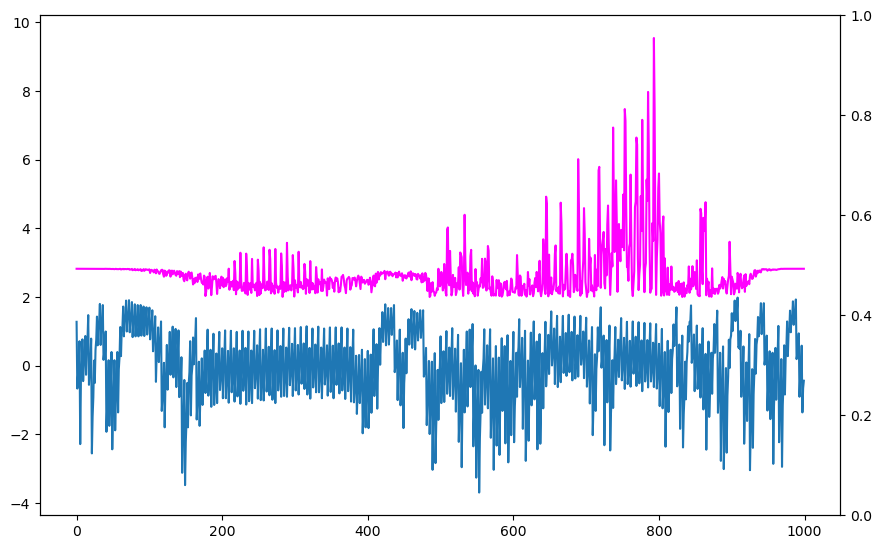

In [56]:
plot_attribution_with_trace(sbox_grads, 141)

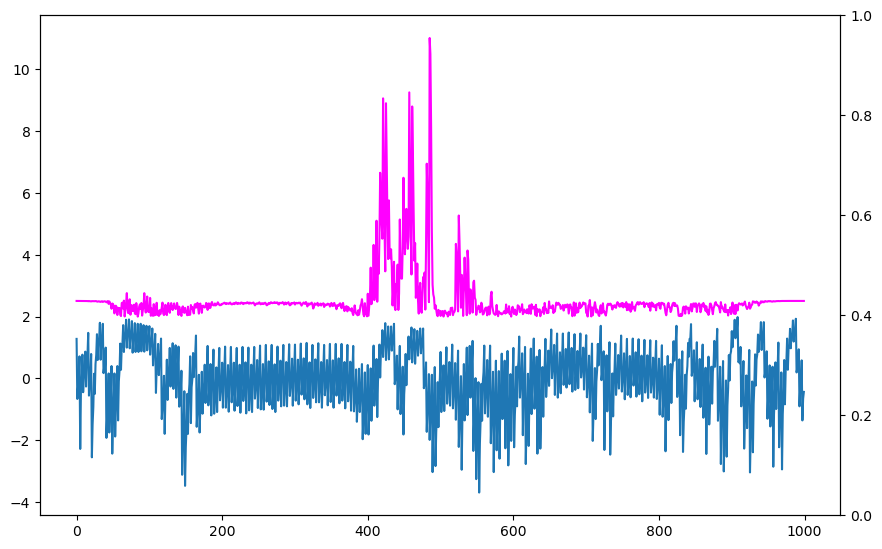

In [57]:
plot_attribution_with_trace(key_grads, 141)

In [ ]:
fig = plt.figure(1,(8.0, 5.0))

ax = fig.add_axes((1.0, 1.0, 1.0, 1.0))
#ax.set_ylim(200.0, 700.0)

grads_mean = grads.cpu().mean()
grads_std =  grads.cpu().std()
grads_norm = (grads.cpu() - grads_mean) / grads_std

ax.plot(np.arange(1000), grads_norm.abs() + 2.0, color='magenta', alpha=1.0)

test_trace = val_test_traces[141][0][:1000]
test_trace_mean = test_trace.mean()
test_trace_std = test_trace.std()
test_trace_norm = (test_trace - test_trace_mean) / test_trace_std

ax2 = ax.twinx()
ax.plot(np.arange(1000), test_trace_norm)

## Occlusion based saliency map